**Implementação dos três algoritmos:**
#### Perceptron Simples , MLP e MLP com duas camadas ocultas.

In [166]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#  outras bibliotecas
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb

from sklearn import preprocessing as pre
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

1) Preparação do Dataframe

In [167]:
# 1.1) Gerando os dados a partir do Dataset
df = pd.read_csv('https://raw.githubusercontent.com/LucasFCO/TP02_IA/main/star_classification.csv')

In [168]:
# 1.2) Etapa de limpeza do DF.
    #Exclusão de dados relacionados a catalogação dos obsjetos.
df = df.drop('obj_ID', axis=1)
df = df.drop('run_ID', axis=1)
df = df.drop('rerun_ID', axis=1)
df = df.drop('spec_obj_ID', axis=1)
df = df.drop('fiber_ID', axis=1)
df = df.drop('cam_col', axis=1)
df = df.drop('plate', axis=1)
df = df.drop('MJD', axis=1)

# Excluindo os Quasares
df = df[df['class'] != 'QSO']

# alterando o rotulo dos objetos
df['class'] = df['class'].replace('GALAXY', 0)
df['class'] = df['class'].replace('STAR', 1)

# separação das variaveis
y = df['class']  # Alvo
X = df.drop('class', axis= 1)  # Preditora

2) Dividindo o conjunto em teste, treino e validação

 Divisão dos dados conforme regras do trabalho (60%, 20%, 20%)

In [169]:
# 60 % do total de amostras é destinada ao treino.
X_treino, X_aux, y_treino, y_aux = train_test_split(X,y , train_size=0.6, random_state=42)

# dos 40% das amostras restantes foram divididas entre teste e valadição 50% para cada.
X_teste, X_validacao, y_teste, y_validacao = train_test_split(X_aux, y_aux, test_size=0.5, random_state=42)


3) Gerandos dados artificiais.
* para balanceamento do conjunto de dados, sera utilizado o modelo de Over Sample, cujo objetivo é aumentar a classe minoritaria.

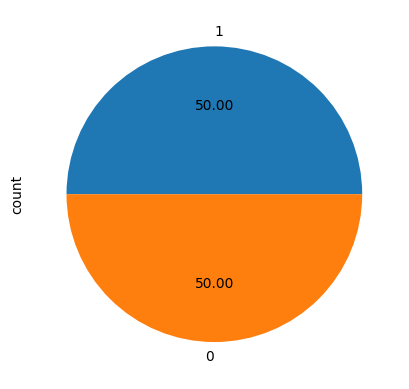

class
1    35704
0    35704
Name: count, dtype: int64

In [170]:
rus = RandomOverSampler(random_state=42)
X_resOs, y_resOs = rus.fit_resample(X_treino, y_treino) #sempre aplicar na base de treino
# visualização
y_resOs.value_counts().plot.pie(autopct = '%.2f')
plt.show()
y_resOs.value_counts()

In [171]:
y_resOs = y_resOs.to_numpy()
X_resOs = X_resOs.to_numpy()

y_teste = y_teste.to_numpy()
X_teste = X_teste.to_numpy()

y_validacao = y_validacao.to_numpy()
X_validacao = X_validacao.to_numpy()

Normalização (Normalization): A normalização é o processo de ajustar os valores das características para uma escala específica, frequentemente entre 0 e 1. A classe MinMaxScaler pode ser utilizada para realizar esse tipo de transformação.

Padronização (Standardization): A StandardScaler é usada para padronizar os dados, ou seja, transformar os dados para que cada feature tenha uma média zero e um desvio padrão de 1. Isso é útil,em algoritmos que são sensíveis à escala dos dados.

In [172]:
# Reshape dos rótulos para se adequar ao formato de saída da rede
y_resOs, y_teste , y_validacao = y_resOs.reshape(-1, 1), y_teste.reshape(-1, 1), y_validacao.reshape(-1, 1)

# X_resOs = pre.MinMaxScaler().fit_transform(X_resOs)
# X_teste = pre.MinMaxScaler().fit_transform(X_teste)

scaler = StandardScaler() # com o Scaler o resultado foi mais preciso
X_resOs = scaler.fit_transform(X_resOs)
X_validacao = scaler.fit_transform(X_validacao)
X_teste = scaler.fit_transform(X_teste)

Algoritmo Perceptron simples

In [173]:
class Perceptron:
    def __init__(self, dim_entrada, taxa_aprendizado=0.01, epocas=100):
        self.dim_entrada = dim_entrada
        self.taxa_aprendizado = taxa_aprendizado
        self.epocas = epocas
        self.pesos = np.random.rand(dim_entrada + 1)  # +1 para o bias
        self.erros = []

    # Funcao Degrau
    def funcao_ativacao(self, x):
        return 1 if x >= 0 else 0

    # Funcao de Predicao
    def predicao(self, X):
        X_with_bias = np.c_[X, np.ones(len(X))]
        return np.array([self.funcao_ativacao(np.dot(x, self.pesos)) for x in X_with_bias])

    # Funcao de treinamento
    def treina(self, X, y):
        X_with_bias = np.c_[X, np.ones(len(X))]
        for _ in range(self.epocas):
            total_erro = 0
            for i in range(len(X_with_bias)):
                erro = y[i] - self.funcao_ativacao(np.dot(X_with_bias[i], self.pesos))
                self.pesos += self.taxa_aprendizado * erro * X_with_bias[i]
                total_erro += int(erro != 0)
            self.erros.append(total_erro)

    def plota_erros(self):
        plt.plot(self.erros, marker='o', label='Erros por iteração')
        plt.xlabel('Iterações')
        plt.ylabel('Número de erros')
        plt.title('Erros de treinamento por iteração')
        plt.legend()
        plt.show()


Algoritmo MLP com uma camada oculta e condição de parada alternativa para aumento do erro.

In [174]:
class MLP:
    def __init__(self, dim_entrada, dim_oculta, dim_saida, taxa_aprendizado=0.01):
        self.dim_entrada = dim_entrada
        self.dim_oculta = dim_oculta
        self.dim_saida = dim_saida
        self.taxa_aprendizado = taxa_aprendizado

        # Inicialização dos pesos e bias das camadas oculta e de saída
        self.pesos_ocultos = np.random.rand(self.dim_entrada, self.dim_oculta)
        self.bias_ocultos = np.zeros(self.dim_oculta)

        self.pesos_saida = np.random.rand(self.dim_oculta, self.dim_saida)
        self.bias_saida = np.zeros(self.dim_saida)

        self.erro_medio_treino = []
        self.erro_medio_validacao = []
    # Funcao de Ativacao Sigmoide
    def sigmoide(self, x):
        return 1 / (1 + np.exp(-x))

    # Derivada Primeirada Funcao de Ativacao Sigmoide
    def sigmoide_derivada(self, x):
        return x * (1 - x)

    # Calculo da saída da rede MLP
    def feedforward(self, X):
        # Calculo da saida da Camada oculta
        camada_oculta_entrada = np.dot(X, self.pesos_ocultos) + self.bias_ocultos
        camada_oculta_saida = self.sigmoide(camada_oculta_entrada)

        # Calculo da saida da Camada de saída
        camada_saida_entrada = np.dot(camada_oculta_saida, self.pesos_saida) + self.bias_saida
        saida = self.sigmoide(camada_saida_entrada)

        return camada_oculta_saida, saida

    def backpropagation(self, X, y, camada_oculta_saida, saida):
        # Backpropagation
        saida_erro = y - saida

        saida_delta = saida_erro * self.sigmoide_derivada(saida)

        camada_oculta_erro = saida_delta.dot(self.pesos_saida.T)
        camada_oculta_delta = camada_oculta_erro * self.sigmoide_derivada(camada_oculta_saida)

        # Atualização dos pesos e bias
        self.pesos_saida += camada_oculta_saida.T.dot(saida_delta) * self.taxa_aprendizado
        self.bias_saida += np.sum(saida_delta, axis=0) * self.taxa_aprendizado

        self.pesos_ocultos += X.T.dot(camada_oculta_delta) * self.taxa_aprendizado
        self.bias_ocultos += np.sum(camada_oculta_delta, axis=0) * self.taxa_aprendizado

    def fit(self, X_treino, y_treino, X_validacao, y_validacao, epocas=1000):
        saida_erro_treino = []
        saida_erro_validacao = []
        somav = 0
        somat = 0
        i = 0
        aux = 0
        for epoca in range(epocas):
            # Forward propagation
            # dados de treino.
            camada_oculta_saida, saida = self.feedforward(X_treino)

            erro_treino = y_treino - saida
            saida_erro_treino.append(erro_treino)
            self.erro_medio_treino.append(np.mean(saida_erro_treino)**2)

            # dados de validação
            camada_oculta_saida_validacao, saida_validacao = self.feedforward(X_validacao) # dados de validacao, não irá para o backpropagation.

            erro_validacao = y_validacao - saida_validacao
            saida_erro_validacao.append(erro_validacao)

            self.erro_medio_validacao.append(np.mean(saida_erro_validacao)**2)

            if aux == 10 :
                if somav > somat:
                    # print('somav maior')
                    break
                aux = 0
            somat += self.erro_medio_treino[i]
            somav += self.erro_medio_validacao[i]
            i +=1
            aux += 1
            # Backpropagation
            self.backpropagation(X_treino, y_treino, camada_oculta_saida, saida)
        print(i ,' ST: ',somat ,' - SV: ',somav)

    def predicao(self, X):
        _, saida = self.feedforward(X)
        return saida

        # Função para plotar a superfície de decisão

    def plot_decision_surface(self, X, y):
      h = .02  # Passo da grade
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      grid_points = np.c_[xx.ravel(), yy.ravel()]

      Z = self.predicao(grid_points)
      Z = Z.reshape(xx.shape)

      cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
      cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

      plt.figure(figsize=(8, 6))
      plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

      # Plotar os pontos de treinamento
      plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)
      plt.xlim(xx.min(), xx.max())
      plt.ylim(yy.min(), yy.max())
      plt.title("Superfície de Decisão da Rede MLP")
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
      plt.show()


Algoritmo MLP com duas camadas ocultas e condição de parada alternativa para aumento do erro..

In [175]:
class MLP2: #codigo com duas camadas
    def __init__(self, dim_entrada, dim_oculta1, dim_oculta2, dim_saida, taxa_aprendizado=0.01):
        self.dim_entrada = dim_entrada
        self.dim_oculta1 = dim_oculta1
        self.dim_oculta2 = dim_oculta2  # segundo parametro
        self.dim_saida = dim_saida
        self.taxa_aprendizado = taxa_aprendizado

        # Inicialização dos pesos e bias das camadas ocultas e de saída
        self.pesos_ocultos1 = np.random.rand(self.dim_entrada, self.dim_oculta1)
        self.bias_ocultos1 = np.zeros(self.dim_oculta1)

        self.pesos_ocultos2 = np.random.rand(self.dim_oculta1, self.dim_oculta2)    # pesos da segunda camada
        self.bias_ocultos2 = np.zeros(self.dim_oculta2)                             # bias da segunda camada oculta

        self.pesos_saida = np.random.rand(self.dim_oculta2, self.dim_saida)
        self.bias_saida = np.zeros(self.dim_saida)

        self.erro_medio_treino = []
        self.erro_medio_validacao = []

    # Funcao de Ativacao Sigmoide
    def sigmoide(self, x):
        return 1 / (1 + np.exp(-x))

    # Derivada Primeirada Funcao de Ativacao Sigmoide
    def sigmoide_derivada(self, x):
        return x * (1 - x)

    # Calculo da saída da rede MLP
    def feedforward(self, X):
        # Calculo da saida da 1ª Camada oculta
        camada_oculta1_entrada = np.dot(X, self.pesos_ocultos1) + self.bias_ocultos1
        camada_oculta1_saida = self.sigmoide(camada_oculta1_entrada)

        # Calculo da saida da 2ª Camada oculta
        camada_oculta2_entrada = np.dot(camada_oculta1_saida, self.pesos_ocultos2) + self.bias_ocultos2
        camada_oculta2_saida = self.sigmoide(camada_oculta2_entrada)

        # Calculo da saida da Camada de saída
        camada_saida_entrada = np.dot(camada_oculta2_saida, self.pesos_saida) + self.bias_saida
        saida = self.sigmoide(camada_saida_entrada)

        return camada_oculta1_saida, camada_oculta2_saida, saida

    def backpropagation(self, X, y, camada_oculta1_saida, camada_oculta2_saida, saida):
        # Backpropagation
        saida_erro = y - saida
        saida_delta = saida_erro * self.sigmoide_derivada(saida)

        # A camada_oculta2_erro é calculada antes da camada_oculta1_erro porque,
        # a saída da segunda camada oculta é utilizada para calcular a saída final.

        camada_oculta2_erro = saida_delta.dot(self.pesos_saida.T)
        camada_oculta2_delta = camada_oculta2_erro * self.sigmoide_derivada(camada_oculta2_saida)

        camada_oculta1_erro = camada_oculta2_delta.dot(self.pesos_ocultos2.T)
        camada_oculta1_delta = camada_oculta1_erro * self.sigmoide_derivada(camada_oculta1_saida)

        # Atualização dos pesos e bias
        self.pesos_saida += camada_oculta2_saida.T.dot(saida_delta) * self.taxa_aprendizado
        self.bias_saida += np.sum(saida_delta, axis=0) * self.taxa_aprendizado

        self.pesos_ocultos2 += camada_oculta1_saida.T.dot(camada_oculta2_delta) * self.taxa_aprendizado
        self.bias_ocultos2 += np.sum(camada_oculta2_delta, axis=0) * self.taxa_aprendizado

        self.pesos_ocultos1 += X.T.dot(camada_oculta1_delta) * self.taxa_aprendizado
        self.bias_ocultos1 += np.sum(camada_oculta1_delta, axis=0) * self.taxa_aprendizado

    def fit(self, X_treino, y_treino, X_validacao, y_validacao, epocas=1000):
        saida_erro_treino = []
        saida_erro_validacao = []
        somav = 0
        somat = 0
        i = 0
        aux = 0
        for epoca in range(epocas):
            # Forward propagation
            # dados de treino.
            camada_oculta1_saida, camada_oculta2_saida, saida = self.feedforward(X_treino)

            erro_treino = y_treino - saida
            saida_erro_treino.append(erro_treino)
            self.erro_medio_treino.append(np.mean(saida_erro_treino)**2)

            # dados de validação
            camada_oculta1_saida_validacao, camada_oculta2_saida_validacao,saida_validacao = self.feedforward(X_validacao) # dados de validacao, não irá para o backpropagation.

            erro_validacao = y_validacao - saida_validacao
            saida_erro_validacao.append(erro_validacao)

            self.erro_medio_validacao.append(np.mean(saida_erro_validacao)**2)

            if aux == 10 :
                if somav > somat:
                    break
                aux = 0
            somat += self.erro_medio_treino[i]
            somav += self.erro_medio_validacao[i]
            i +=1
            aux += 1

            # Backpropagation
            self.backpropagation(X_treino, y_treino, camada_oculta1_saida, camada_oculta2_saida, saida)
        print(i ,' ST: ',somat ,' - SV: ',somav)

    def predicao(self, X):
        _, _, saida = self.feedforward(X)
        return saida


    # Função para plotar a superfície de decisão
    def plot_decision_surface(self, X, y):
      h = .02  # Passo da grade
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      grid_points = np.c_[xx.ravel(), yy.ravel()]

      Z = self.predicao(grid_points)
      Z = Z.reshape(xx.shape)

      cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
      cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

      plt.figure(figsize=(8, 6))
      plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

      # Plotar os pontos de treinamento
      plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)
      plt.xlim(xx.min(), xx.max())
      plt.ylim(yy.min(), yy.max())
      plt.title("Superfície de Decisão da Rede MLP")
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
      plt.show()

## **Parte de testes.**

1) Modelo Perceptrom

In [176]:
modelo = Perceptron(dim_entrada=9, taxa_aprendizado=0.1, epocas=800) # se subir o numero de epocas o algoritmo perde a precisão
modelo.treina(X_resOs[:150], y_resOs[:150])

previsto = modelo.predicao(X_teste)

acuracia = np.mean(previsto ==  y_teste)*100
# modelo.plota_erros()

matriz1 = confusion_matrix(y_teste, previsto)


C:\Users\Lucas\AppData\Local\Temp\ipykernel_7516\665550272.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_erro += int(erro != 0)


2) Criando e treinando a MLP

In [177]:
quantidade_dimensoes = 9 #um valor qualquer entre 1 e 8, represnta as features do df.
epocas = 1000# numero limite de quantas vezes o modelo passará pelo df.
quantidade_treinamento = 150  # o dimensionamento de quantidades é apenas para ter um ajuste mais controlado em menor tempo.
dim_oculta= 30

mlp = MLP(dim_entrada=quantidade_dimensoes, dim_oculta=dim_oculta, dim_saida=1, taxa_aprendizado=0.1)
# execução do donjuto de treinamento.
mlp.fit(X_resOs[0:quantidade_treinamento, 0:quantidade_dimensoes], y_resOs[0:quantidade_treinamento], X_validacao[0:quantidade_treinamento, 0:quantidade_dimensoes], y_validacao[0:quantidade_treinamento] ,epocas=epocas)
# execução do donjuto de validação.
# mlp.fit(X_validacao[0:quantidade_treinamento, 0:quantidade_dimensoes], y_validacao[0:quantidade_treinamento], epocas=epocas, validacao= True)

# execução do conjuto de destes
saida_prevista = mlp.predicao(X_teste[:, 0:quantidade_dimensoes])

# Convertendo as previsões para classes (0 ou 1)
predicao_classes = (saida_prevista > 0.5).astype(int)

acuracia2 = np.mean(predicao_classes == y_teste)*100

matriz2 = confusion_matrix(y_teste, predicao_classes)


300  ST:  4.2132526656468485  - SV:  4.249300668888922


3) Criando e treinando a MLP com duas camadas

*   Item da lista
*   Item da lista



In [178]:
quantidade_dimensoes = 9 #um valor qualquer entre 1 e 8, represnta as features do df.
epocas = 1000# numero limite de quantas vezes o modelo passará pelo df.
quantidade_treinamento = 150  # o dimensionamento de quantidades é apenas para ter um ajuste mais controlado em menor tempo.
dim_oculta1= 62
dim_oculta2= 55

mlp = MLP2(dim_entrada=quantidade_dimensoes, dim_oculta1=dim_oculta1, dim_oculta2=dim_oculta2,dim_saida=1, taxa_aprendizado=0.1)
# mlp.fit(X_resOs[0:quantidade_treinamento, 0:quantidade_dimensoes], y_resOs[0:quantidade_treinamento], epocas=epocas)
mlp.fit(X_resOs[0:quantidade_treinamento, 0:quantidade_dimensoes], y_resOs[0:quantidade_treinamento], X_validacao[0:quantidade_treinamento, 0:quantidade_dimensoes], y_validacao[0:quantidade_treinamento] ,epocas=epocas)


saida_prevista = mlp.predicao(X_teste[:, 0:quantidade_dimensoes])
# Convertendo as previsões para classes (0 ou 1)
predicao_classes = (saida_prevista > 0.5).astype(int)
acuracia3= np.mean(predicao_classes == y_teste)*100

matriz3 = confusion_matrix(y_teste, predicao_classes)

10  ST:  5.377777235136067  - SV:  5.475999400941386


## **Parte de visualização dos resultados**

In [179]:
print(f'Acurácia Perceptron: {round(acuracia,2)} %')
print(f'Acurácia da MLP: {round(acuracia2,2)} %')
print(f'Acurácia da MLP2: {round(acuracia3,2)} %')

Acurácia Perceptron: 52.15 %
Acurácia da MLP: 81.45 %
Acurácia da MLP2: 27.14 %


In [184]:
len(y_teste)

16208

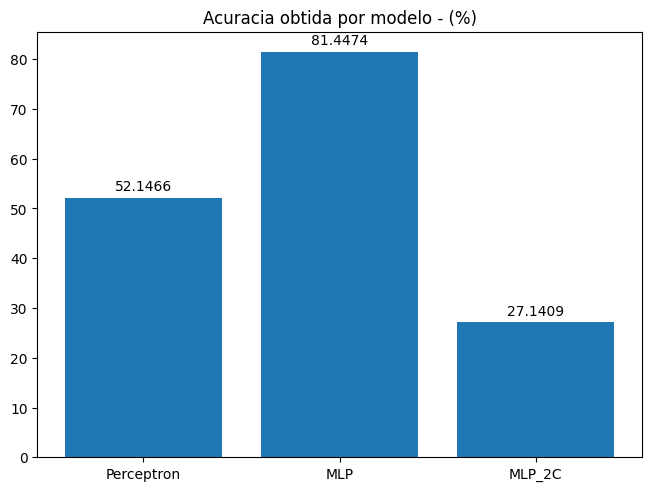

In [180]:
y = [acuracia , acuracia2 , acuracia3]
mods = ["Perceptron", "MLP", "MLP_2C"]

fig1, ax1 = plt.subplots(layout='constrained')

rec = ax1.bar(mods, y)

ax1.bar_label(rec, padding=3)
ax1.set_title('Acuracia obtida por modelo - (%)')

plt.show()

Text(627.9949494949494, 0.5, 'Real')

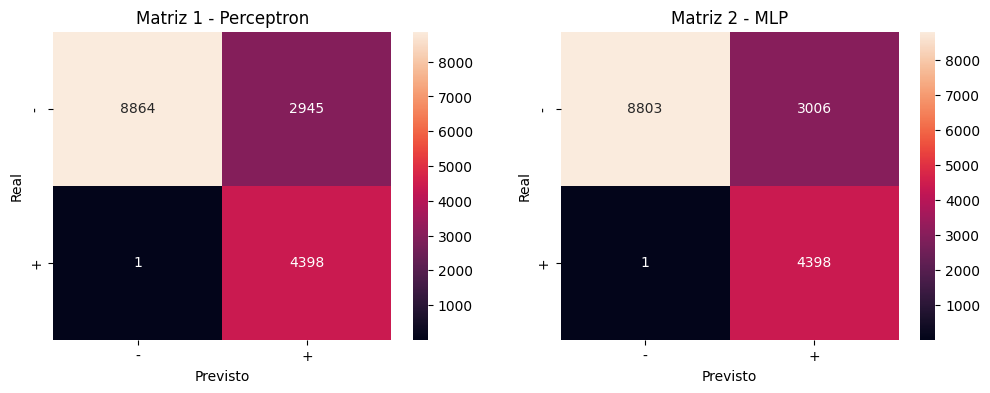

In [181]:
figura = plt.figure(figsize=(12,4))
xticklabels = '-', '+'
yticklabels = '-', '+'

figura.add_subplot(121)
fig = sb.heatmap((matriz1),annot=True, fmt='.0f',  xticklabels=xticklabels, yticklabels=yticklabels)
plt.title('Matriz 1 - Perceptron')
plt.xlabel('Previsto')
plt.ylabel('Real')

figura.add_subplot(122)
plt.title('Matriz 2 - MLP')
fig2 = sb.heatmap((matriz2),annot=True, fmt='.0f',  xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Previsto')
plt.ylabel('Real')

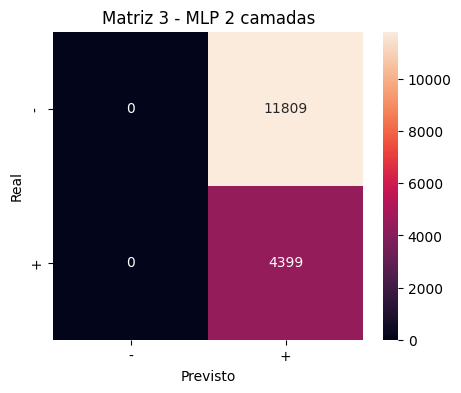

In [182]:
figura = plt.figure(figsize=(5,4))
figura.add_subplot(111)
plt.title('Matriz 3 - MLP 2 camadas')
fig3 = sb.heatmap((matriz3),annot=True, fmt='.0f',  xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Previsto')
plt.ylabel('Real')
# figura.add_subplot(222)
plt.show(figura)

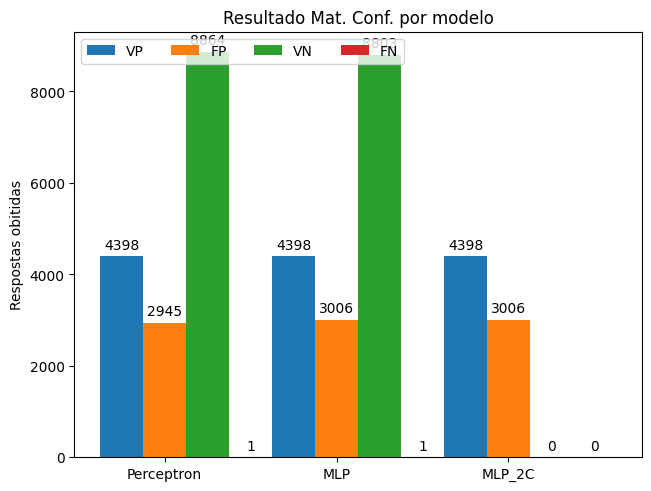

In [183]:
vp1 = matriz1[1][1]
fp1 = matriz1[0][1]
vn1 = matriz1[0][0]
fn1 = matriz1[1][0]

vp2 = matriz2[1][1]
fp2 = matriz2[0][1]
vn2 = matriz2[0][0]
fn2 = matriz2[1][0]

vp3 = matriz2[1][1]
fp3 = matriz2[0][1]
vn3 = matriz3[0][0]
fn3 = matriz3[1][0]

modelos = ("Perceptron", "MLP", "MLP_2C")
mat_conf = {
    'VP': (vp1,vp2,vp3),
    'FP': (fp1,fp2,fp3),
    'VN': (vn1,vn2,vn3),
    'FN': (fn1, fn2, fn3)

}
# print(mat_conf)
x = np.arange(len(modelos))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in mat_conf.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Rorulos
ax.set_title('Resultado Mat. Conf. por modelo')
ax.set_ylabel('Respostas obitidas')
ax.set_xticks(x + width, modelos)
ax.legend(loc='upper left', ncols=4)
plt.show()